In [1]:
#در این قسمت کتابخانه های هضم و فست تکست و مدل استفاده شده در فست تکست برای امبدینگ کلمات فارسی را دانلود میکنیم
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
!gunzip cc.fa.300.bin.gz

!pip install fasttext


import fasttext 

model = fasttext.load_model("cc.fa.300.bin")

!pip install hazm

--2021-06-26 10:35:23--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4502524724 (4.2G) [application/octet-stream]
Saving to: ‘cc.fa.300.bin.gz’

cc.fa.300.bin.gz     25%[====>               ]   1.05G  19.7MB/s    in 55s     

2021-06-26 10:36:19 (19.5 MB/s) - Read error at byte 1127029288/4502524724 (Connection reset by peer). Retrying.

--2021-06-26 10:36:20--  (try: 2)  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 4502524724 (4.2G), 3375495436 (3.1G) remaining [application/octet-stream]
Saving to: ‘cc.fa.300.bin.gz’

cc

In [2]:
#در این قسمت ابتدا داده ها را از اکسل که در فضای درایو هست میگیریم و دو صفحه ی ان را یکی میکنیم
import fasttext 
import pandas
import random
import numpy
import hazm

from google.colab import drive
drive.mount('/content/drive')

path=('/content/drive/MyDrive/Labeled-Sentences.xlsx')

data0=pandas.read_excel(path,sheet_name=0)
data1=pandas.read_excel(path,sheet_name=1)

data=pandas.DataFrame({'review':list(data0['review'])+list(data1['Unnamed: 0']),'label':list(data0['label'])+list(data1['label'])})
 
 #اینجا مقادیر نال را حذف میکنیم
data.dropna(subset = ["review"], inplace=True)
print(data)

# این قسمت با استفاده از کتابخانه هضم قسمت ریویو ها یعنی متن نظرات را نرمال سازی میکنیم. مانند درست کردن نیم فاصله ها و حذف کردن اموجی ها و حروف رابطه و غیره    
def CleanPersianText(text):
  _normalizer = hazm.Normalizer()
  text = _normalizer.normalize(text)
  return text

#در این قسمت یک لیست از متن های نرمال شده و لیبل ها درست میکنیم
revlist = list(map(lambda x: [CleanPersianText(x[0]), (x[1])],zip(data['review'],data['label'])))

print(len(revlist))

print(revlist)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                                 review  label
0     سلام من یک ماه پیش در هتل شمس قشم بودم واقعا ه...      2
1     سلام بنده با همراه خانوادم چهار روز در این هتل...      2
2     ما از تاریخ ۵اسفند ۹۶تا۸اسفند ۹۶ در این هتل اق...      2
3     من 2روز در اين هتل به همراه همسرم اقامت داشتم ...      2
4     سفر بسیار خوبی بود هتل بسیار زیبا و قشنگی بود ...      2
...                                                 ...    ...
1628      هتل بسيار تميز و داراي استانداردهاي روز دنيا       2
1629                                 طراحي مدرن و عالي       2
1630                 پرسنل آموزش ديده جوان و تحصيلكرده       2
1631                           اتاقهاي فوق العاده تميز       2
1632             . من واقعا أقامت آرامي را تجربه كردم .      2

[1632 rows x 2 columns]
1632
[['سلام من یک ماه پیش در هتل شمس قشم بودم واقعا هتل خوبی بود …از لحاظ نزدیکی به دریا 

In [4]:
#  در این قسمت نوع لیبل ها را مشخص میکینم و تعداد پراکندگی هر کدام از انها را چاپ میکنیم
excellent=list(filter(lambda x: x[1] == 2,revlist))
good=list(filter(lambda x: x[1] == 1,revlist))
bad=list(filter(lambda x: x[1] == 0,revlist))


print("excellent count {}".format(len(excellent)))
print("good count {}".format(len(good)))
print("bad  count {}".format(len(bad)))

#در این قسمت تعداد حداکثر توکن ها و سایز بردار های عددی که از کلمات ساخته میشود را مشخص میکنیم
import numpy as np
import keras.backend as K

vector_size = 300 
max_no_tokens = 500

#در این قسمت تعداد داده های تست و ترین را مشخص میکنیم
train_size = int(0.8*(len(revlist)))
test_size = int(0.2*(len(revlist)))



indexes = set(np.random.choice(len(revlist), train_size + test_size, replace=False))

x_train = np.zeros((train_size, max_no_tokens, vector_size), dtype=K.floatx())
y_train = np.zeros((train_size, 3), dtype=np.int32)

x_test = np.zeros((test_size, max_no_tokens, vector_size), dtype=K.floatx())
y_test = np.zeros((test_size, 3), dtype=np.int32)


# در این قسمت با استفاده از مدلی که در قسمت اول کد از فست تکست دانلود کردیم توکن ها را به بردار های عددی تبدیل میکنیم
for i, index in enumerate(indexes):
  text_words = hazm.word_tokenize(revlist[index][0])
  for t in range(0,len(text_words)):
    if t >= max_no_tokens:
      break
    
    if text_words[t] not in model.words:
      continue
    if i < train_size:
      x_train[i, t, :] = model.get_word_vector(text_words[t])
    else:
      x_test[i - train_size, t, :] = model.get_word_vector(text_words[t])


#در این قسمت مدل نمایش لیبل ها را مشخص میکنیم
  if i < train_size:
    if revlist[index][1] == 0:
      y_train[i, :] = [1.0, 0.0, 0.0] 
    if revlist[index][1] == 1:
      y_train[i, :] = [0.0, 1.0, 0.0]
    if revlist[index][1] == 2:
      y_train[i, :] = [0.0, 0.0, 1.0]

  else:
    if revlist[index][1] == 0:
      y_test[i - train_size, :] = [1.0, 0.0, 0.0]
    if revlist[index][1] == 1:
      y_test[i - train_size, :] = [0.0, 1.0, 0.0]
    if revlist[index][1] == 2:
      y_test[i - train_size, :] = [0.0, 0.0, 1.0]
    


excellent count 1202
good count 166
bad  count 264


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1665024   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 1,929,219
Trainable params: 1,929,219
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6/6 [==============================] - 24s 562ms/step - loss: 1.7521 - accuracy: 0.1598 - val_loss:

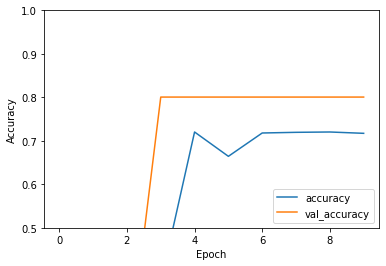

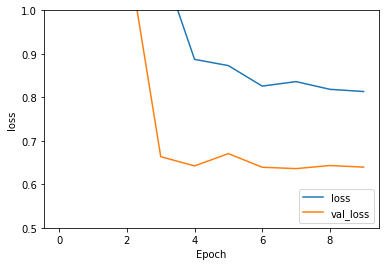

11/11 [==============================] - 0s 42ms/step - loss: 0.6395 - accuracy: 0.8006
test_loss = 0.6395060420036316
test _acc = 0.800613522529602


INFO:tensorflow:Assets written to: mymodel.model/assets


INFO:tensorflow:Assets written to: mymodel.model/assets


In [5]:

#در این قسمت شبکه ی خود را با کراس درست میکنیم و مدل خود را روی داده تست ارزیابی میکنیم و مقدار دقت و خطا و نمودار ان ها را رسم میکنیم
batch_size = 250 
no_epochs = 10

from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional, Embedding
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard

#این قسمت مربوط به شبکه با یک لایه ال اس تی ام است
DeepModel = Sequential()

DeepModel.add(LSTM(512, input_shape=(max_no_tokens, vector_size)))#, return_sequences= True))
DeepModel.add(Dropout(0.25))
DeepModel.add(Dense(512, activation='sigmoid'))
DeepModel.add(Dropout(0.25))
DeepModel.add(Dense(3, activation='softmax'))



'''این قسمت مربوط به شبکه بازگشتی ال اس تی ام دو طرفه است
DeepModel.add(Conv1D(32, kernel_size=3, activation='elu', padding='same',
                 input_shape=(max_no_tokens, vector_size)))
DeepModel.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.3)))
DeepModel.add(Dense(512, activation='sigmoid'))
DeepModel.add(Dropout(0.25))
DeepModel.add(Dense(3, activation='softmax'))
'''


'''
این قسمت مربوط به قسمت امتیازی شبکه کانولوشن است
DeepModel.add(Conv1D(32, kernel_size=3, activation='elu', padding='same',
                 input_shape=( max_no_tokens, vector_size)))
DeepModel.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
DeepModel.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
DeepModel.add(MaxPooling1D(pool_size=3))
DeepModel.add(Dropout(0.25))
DeepModel.add(Flatten())
DeepModel.add(Dense(512, activation='sigmoid'))
DeepModel.add(Dropout(0.2))
DeepModel.add(Dense(512, activation='sigmoid'))
DeepModel.add(Dropout(0.25))
DeepModel.add(Dense(512, activation='sigmoid'))
DeepModel.add(Dropout(0.25))
DeepModel.add(Dense(3, activation='softmax'))
'''



DeepModel.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])


DeepModel.summary()

history = DeepModel.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=no_epochs,validation_data=(x_test, y_test))

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = DeepModel.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)
print('test_loss =', test_loss)
print("test _acc =", test_acc)



DeepModel.save('mymodel.model')

In [6]:
#در این قسمت متنی را گرفته و مدل ما لیبل ان را سعی میکند پیشبینی کند
user_text = "امکانات هتل عالی بود"
from IPython.core.display import display, HTML
_normalizer = hazm.Normalizer()
if not user_text=="":
  text_for_test = _normalizer.normalize(user_text)
  text_for_test_words = hazm.word_tokenize(text_for_test)
  x_text_for_test_words = np.zeros((1,max_no_tokens,vector_size),dtype=K.floatx())
  for t in range(0,len(text_for_test_words)):
    if t >= max_no_tokens:
      break
    if text_for_test_words[t] not in model.words:
      continue
    
    x_text_for_test_words[0, t, :] = model.get_word_vector(text_for_test_words[t])
  
  result = DeepModel.predict(x_text_for_test_words)
  print(numpy.argmax(result))

2
